In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# Install PySpark

In [2]:
!pip install PySpark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os

print('Import Libraries')

Import Libraries


In [4]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate() 

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 20:11:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# Combined Dataset
* loan_amnt
* emp_length
* dti
* addr_state
* policy_code
* accepted_flag

In [6]:
# Accpeted
accepted_df = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'policy_code', 'accepted_flag')

# Rejected
rejected_df = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumnRenamed('State', 'addr_state') \
                         .withColumnRenamed('Policy Code', 'policy_code') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'policy_code', 'accepted_flag')

In [7]:
# Combine 2 datsets
combined_df = accepted_df.union(rejected_df)

combined_df = combined_df.withColumn('emp_length_years',
                       when(col('emp_length') == '< 1 year', 0)
                       .when(col('emp_length') == '1 year', 1)
                       .when(col('emp_length') == '2 years', 2)
                       .when(col('emp_length') == '3 years', 3)
                       .when(col('emp_length') == '4 years', 4)
                       .when(col('emp_length') == '5 years', 5)
                       .when(col('emp_length') == '6 years', 6)
                       .when(col('emp_length') == '7 years', 7)
                       .when(col('emp_length') == '8 years', 8)
                       .when(col('emp_length') == '9 years', 9)
                       .when(col('emp_length') == '10+ years', 10)
                       .when(col('emp_length').isNull(), -1)
                       .otherwise(-1))

combined_df = combined_df.drop('emp_length')

# Handle Null values

In [8]:
from pyspark.sql.functions import col, sum as spark_sum

# Drop'loan_amnt' and 'dti' Null values

combined_df.dropna(subset=['loan_amnt', 'dti']) \
           .select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in combined_df.columns
]).toPandas()

,loan_amnt,dti,addr_state,policy_code,accepted_flag,emp_length_years
0,0,0,22,918,0,0


In [9]:
combined_df = combined_df.withColumn('policy_code', col('policy_code').cast('string')) \
                         .dropna(subset = ['loan_amnt', 'dti']) \
                         .fillna('unknown', subset = ['addr_state', 'policy_code'])

combined_df.count()

29907698

# Encode Categorical Variables 

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categorical_cols = ["addr_state", "policy_code"]

# StringIndexer — turns strings into numeric category indices
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in categorical_cols
]

# OneHotEncoder — turns those indices into binary vectors, so there's no ordering
encoders = [
    OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_vec")
    for c in categorical_cols
]

# Assemble Features

* features: contains a single vector of all features per row
* label: the outcome trying to predict

In [11]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["loan_amnt", "dti", "emp_length_years"] + [c+"_vec" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split into Train and Test Sets (80:20) 
with random_state(seed) = 42

In [12]:
train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

## Train the Logistic Regression Model

In [13]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])
model = pipeline.fit(train_df)

## Coefficients

**Early read**: there are some extreme positive/negative coefficients

**Next step**: Map coefficient back to each feature to spot leak channels

In [14]:
lr_model = model.stages[-1]
print(lr_model.coefficients)

[1.096302269771589e-06,-7.866207239568027e-07,0.12335969755511171,0.02444547611701913,-0.01396691383801554,-0.015019836065513844,0.02030365467510789,-0.022558701156822503,-0.013839889656227252,0.01441071624262537,-0.010193516033161761,0.0236267639361022,-0.01397820156951371,-0.0050518260603090925,0.008263774079601839,0.014672923936338952,0.011718332603437666,-0.03089550831497946,0.021939149116990176,-0.011715686653506335,0.021063753953072858,-0.01237432379402495,-0.03827879810850071,0.027561760033391825,-0.035941662578112085,-0.03139312332212749,0.04410850173828946,0.002986029138845404,0.041051465933445906,-0.026055572238591326,0.027368204164907976,-0.021525913124545902,0.015845716669709877,-0.03419754841238663,-0.05097572552799102,0.0030909131371911042,0.003964581091864123,-0.017377378880303936,-0.019264609439733665,0.020018237498868077,0.010786136554287364,-0.02549444775989643,0.014202938241314151,-0.017832919351346472,-0.046850468422487045,-0.03077516330839989,0.007502339304310314,0

## Predictions

In [15]:
predictions = model.transform(test_df)
predictions.select("accepted_flag", "prediction", "probability").show()

+-------------+----------+--------------------+
|accepted_flag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       1.0|[1.21460540006558...|
|            1|       1.0|[1.59487351917949...|
|            1|       1.0|[1.06157027660719...|
|            1|       1.0|[1.39534549485303...|
|            1|       1.0|[1.56980500111131...|
|            1|       1.0|[1.59433652495956...|
|            1|       1.0|[1.09280001823072...|
|            1|       1.0|[4.48594646049098...|
|            1|       1.0|[4.60751040989100...|
|            1|       1.0|[1.59398698833057...|
|            1|       1.0|[1.35785914653217...|
|            1|       1.0|[1.73735960076719...|
|            1|       1.0|[6.65335507681848...|
|            1|       1.0|[1.52204214918534...|
|            1|       1.0|[1.24419188936549...|
|            1|       1.0|[1.38715249601910...|
|            1|       1.0|[4.60266161291823...|
|            1|       1.0|[4.42921610662

## Evaluations

### 1. Classification Report & Confusion Matrix

              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00   5530396
    Accepted       1.00      1.00      1.00    451987

    accuracy                           1.00   5982383
   macro avg       1.00      1.00      1.00   5982383
weighted avg       1.00      1.00      1.00   5982383



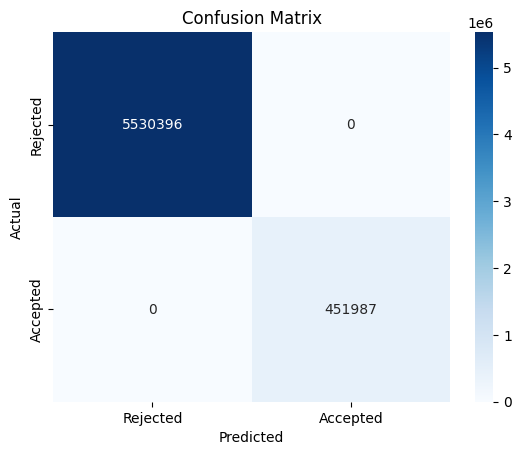

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 2. AUC

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

AUC: 0.9999997086732064


# Imbalance and Data Leakage Review

### 1. Check the % of accepted_flag in Train and Test set

In [18]:
# Calculate % in train_df
train_total = train_df.count()

train_percentage = train_df.groupBy('accepted_flag') \
    .count() \
    .withColumnRenamed('count', 'train_count') \
    .withColumn('train_percentage', round((col('train_count') / train_total) * 100, 2))

# Calculate % in test_df
test_total = test_df.count()

test_percentage = test_df.groupBy('accepted_flag') \
    .count() \
    .withColumnRenamed('count', 'test_count') \
    .withColumn('test_percentage', round((col('test_count') / test_total) * 100, 2))

# Overview
split = train_percentage.join(test_percentage, 'accepted_flag')
split = split.orderBy('accepted_flag').toPandas()
split

,accepted_flag,train_count,train_percentage,test_count,test_percentage
0,0,22118345,92.45,5530396,92.44
1,1,1806970,7.55,451987,7.56


### 2. Check for DTI outliers

In [19]:
# Descriptive stats - red flag of data quality issue

combined_df.select("dti").describe().toPandas()

,summary,dti
0,count,29907698
1,mean,133.93524948045496
2,stddev,10133.387168685706
3,min,-1.0
4,max,5.000003149E7


In [20]:
# Loans with invalid dti 

combined_df.filter((col('dti') < 0) | (col('dti') > 100)).groupBy('accepted_flag').count().orderBy('accepted_flag').toPandas()

,accepted_flag,count
0,0,2011034
1,1,2563


In [21]:
# DTI outlier distribution

combined_df.withColumn('dti_bucket', floor(col('dti') / 100) * 100) \
           .groupBy('dti_bucket') \
           .count() \
           .filter(col('dti_bucket') >= 100) \
           .orderBy('dti_bucket').toPandas()

,dti_bucket,count
0,100,1664035
1,200,123137
2,300,78550
3,400,50450
4,500,32406
...,...,...
1628,3974400,1
1629,4408800,1
1630,7130300,1
1631,7374800,1


In [22]:
# Descriptive stats after excluding DTI Outliers

combined_df.filter((col('dti') >= 0) & (col('dti') <= 100)).select('dti').describe().toPandas()

,summary,dti
0,count,27894101
1,mean,25.930588497524862
2,stddev,23.81351897625889
3,min,0.0
4,max,100.0


### 3. Check for policy_code values

In [23]:
# 'policy_code' distribution across Accepted and Rejected loans 

combined_df.groupBy("policy_code", "accepted_flag").count().orderBy("policy_code", "accepted_flag").toPandas()

,policy_code,accepted_flag,count
0,0.0,0,27559694
1,1.0,1,2258957
2,2.0,0,88129
3,unknown,0,918
